<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/RAG/Extract_from_Images/Rag_Langchain_Ollama_LLama3_2_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Information from Documents using a Multimodal Model

- https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/

- https://ollama.com/library/llama3.2-vision

- https://developers.googleblog.com/en/gemini-15-pro-and-15-flash-now-available/

- https://github.com/RapidAI/RapidOCR

- https://pymupdf.readthedocs.io/en/latest/

# Pydantic
Pydantic is the most widely used data validation library for Python.

- https://docs.pydantic.dev/latest/



In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture output
! pip install -r /content/drive/MyDrive/models/requirements.txt -qqq

In [ ]:
! pip install rapidocr-onnxruntime

# Install Ollama
- curl https://ollama.ai/install.sh | sh

- Run server with: ollama serve &

- Pull model ollama pull llama3.2-vision

In [4]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))



In [36]:
import sys, pymupdf  # import the bindings
fname = "/content/drive/MyDrive/data/Contribution Form Juan Huertas 26012025.pdf"  # path to the PDF file
doc = pymupdf.open(fname)  # open document
for page in doc:  # iterate through the pages
    pix = page.get_pixmap()  # render page to an image
     # Zoom in the image
    zoom_x = 2.0  # horizontal zoom
    zoom_y = 2.0  # vertical zoom
    mat = pymupdf.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
    pix = page.get_pixmap(matrix=mat)
    im = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    im = im.convert("RGB")
    im.save("/content/drive/MyDrive/data/page-%i.png" % page.number)  # store image as a PNG
    print(f"image size {im.size}")

image size (1222, 1682)
image size (1222, 1682)
image size (1222, 1682)
image size (1222, 1682)
image size (1222, 1682)
image size (1222, 1682)
image size (1222, 1682)
image size (1222, 1682)


In [7]:
from rapidocr_onnxruntime import RapidOCR, VisRes
def create_engine_rapidocr():
    """
    Create RapidOCR Engine
    return:
    RapidOCR Engine
    """
    # create RapidOCR Engine
    engine = RapidOCR(det_model_type="DB", rec_model_type="CRNN")
    return engine

def ocr_to_text(ocr_output):
    """
    # Sort the OCR output based on the y-coordinate of the bounding box
    each element of the list is another list wihich contain 3 elements

        element 0 bounding box coordinates

        element 1 Text extracted

        element 2 score

        Example:

        [[[529.0, 149.0], [577.0, 149.0], [577.0, 174.0], [529.0, 174.0]],
        'R&D',
        0.9749892751375834]
    Args:
        ocr_output : list of lists, output from Rapid OCR
    """
    # Sort the OCR output based on the y-coordinate of the bounding box
    sorted_ocr = sorted(ocr_output, key=lambda x: x[0][0][1])

    # Initialize variables
    lines = []
    current_line = []
    current_y = sorted_ocr[0][0][0][1]

    # Iterate through the sorted OCR output
    for item in sorted_ocr:
        bbox, text, score = item
        bbox_y = bbox[0][1]

        # Check if the bounding box is on the same line as the current line
        if abs(bbox_y - current_y) <= 10:
            current_line.append(text + " ")
        else:
            lines.append(" ".join(current_line))
            current_line = [text + " "]
            current_y = bbox_y

    # Append the last line
    if current_line:
        lines.append(" ".join(current_line))

    # Join all lines into a single text output
    text_output = "\n".join(lines)
    return text_output

In [8]:
engine = create_engine_rapidocr()

In [9]:
file_path = "/content/drive/MyDrive/data/page-0.png"
pil_image = Image.open(file_path)
pil_image = pil_image.convert("RGB")

In [37]:
temp_path = "/content/drive/MyDrive/data/page-0-temp.png"
pil_image.save(temp_path)

result, vis = engine(temp_path)

In [39]:
vis

[0.5118240889996741, 0.03702592849731445, 0.7515685558319092]

In [11]:
extracted_text = ocr_to_text(result)
extracted_text

"iiSIPP \ninteractive \nContributionform \ninvestor \n1of8 \nHowtocompletethisform \nUsethisform tomakeasinglepersonal contributionbybanktransfer,setuparegularmonthlypersonal \ncontributionbydirectdebitorto arrange contributionsfromyour employeroranotherperson[thirdparty]. \nImportant:AllcontributionstoyourSiPP,togetherwithcontributionstoanyotherpensionsyoumayhave \ncounttowardsyourAnnualAllowanceor,whereapplicable,theMoneyPurchaseAnnualAllowance. \nOncecompleted,pleasesavethisform,andsendviasecuremessagefromyouronlineaccount.Havingsent \nthe completed form tous,singlepaymentsshouldbemade as detailed inSection5. \nSection1-Accountholder'sdetails \nSurmame  Firstname[s)  Title \nHuertasRomero  Juan Salvador  Mr \nNational InsuranceNumber  SIPPAccountNumber \nZ  8  C  3  6  8  7  5  5  S  6  5 \n口No  Yes  Areyouregisteredforanyformof LifetimeAllowance[LTA]protection? \nIfyouappliedtotheHMRCforprotectionitwillbeEnhanced,Fixed,IndividualorPrimary.Youwillose \nEnhanced orFixedProtectionif y


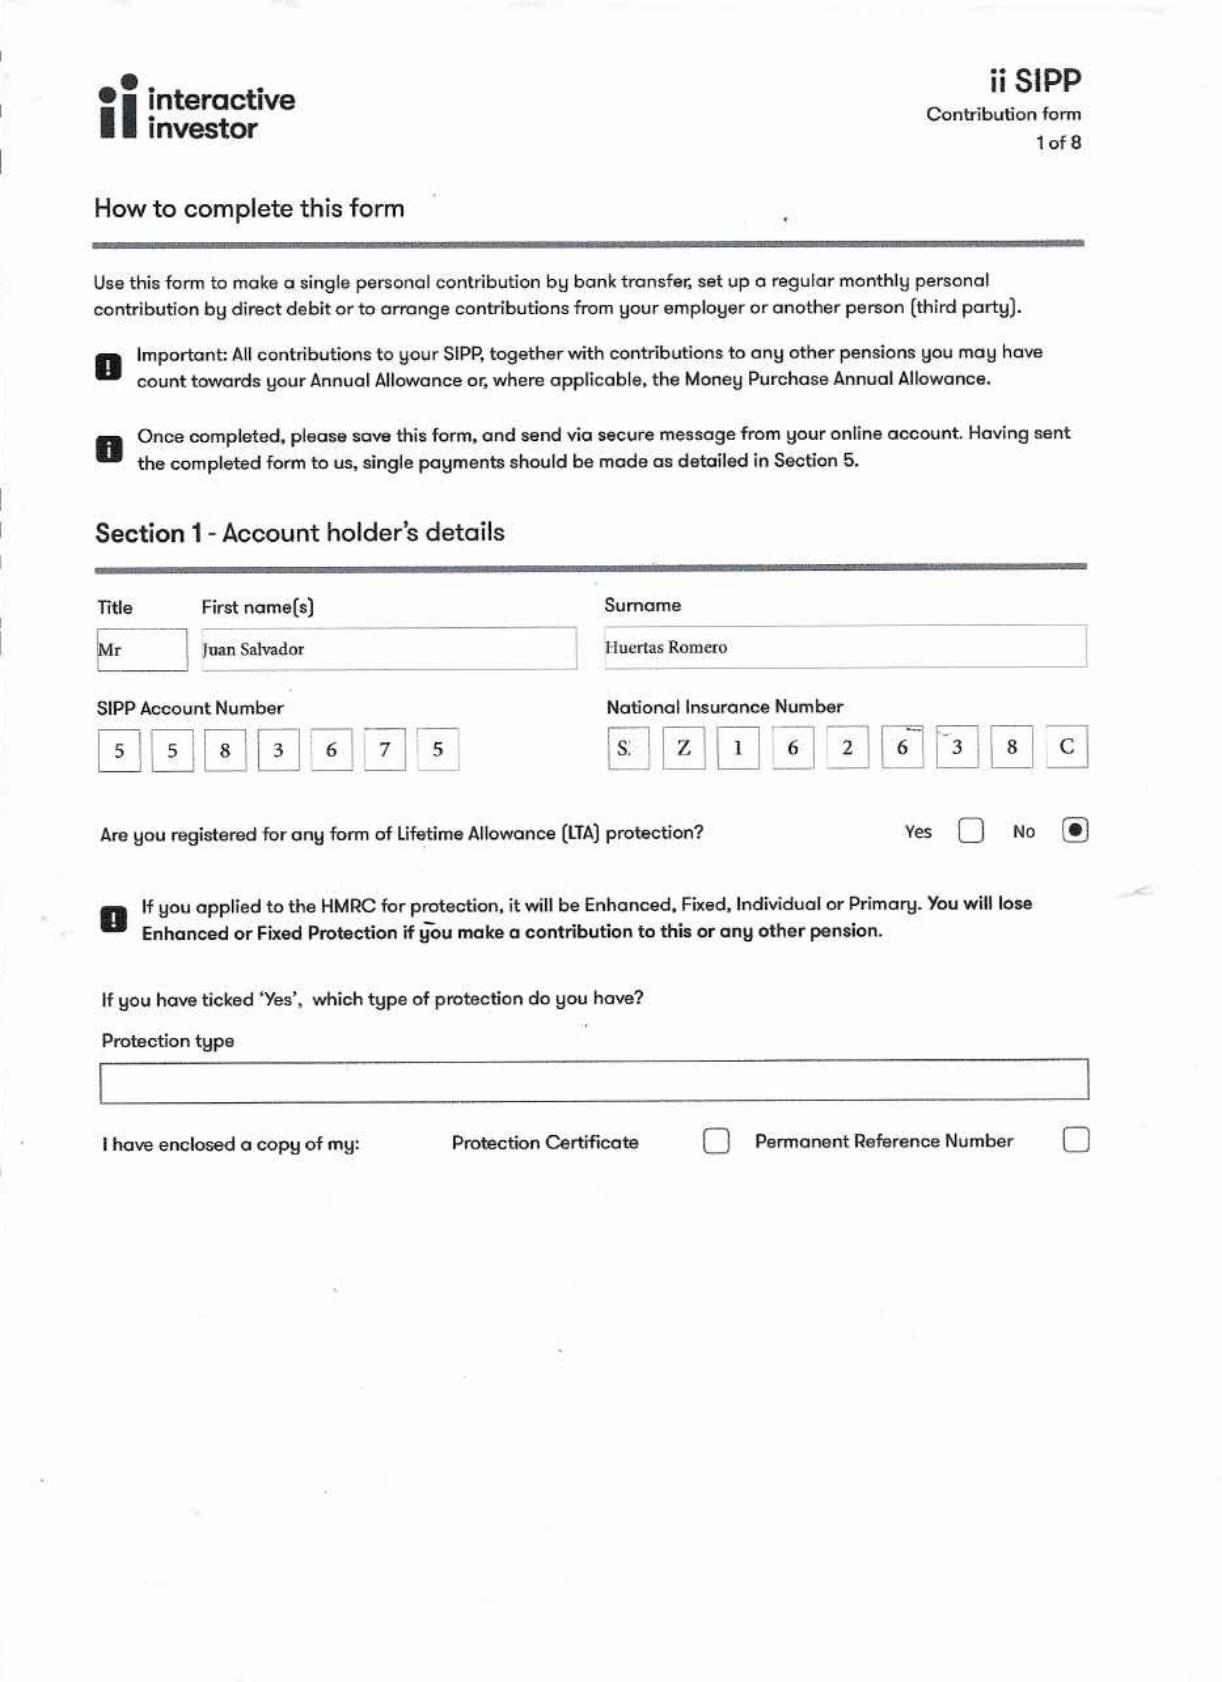

In [12]:
file_path = "/content/drive/MyDrive/data/page-0.png"
pil_image = Image.open(file_path)
image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

# LLama 3.2 Vision 11 Billones Parameters

https://ollama.com/library/llama3.2-vision

ollama pull llama3.2-vision




In [13]:
from typing import Optional

from pydantic import BaseModel, Field


class Person(BaseModel):
    """Information about a person."""

    title: Optional[str] = Field(default=None, description="The title of the person.")
    first_name: Optional[str] = Field(default=None, description="The First name of the Account Holder")
    surname: Optional[str] = Field(default=None, description="The Surname of the Account Holder")
    sipp_account_number : Optional[str] = Field(default=None, description="The Sipp Account Number of the Account Holder. 7 numbers")
    national_insurance_number : Optional[str] = Field(default=None, description="The National Insurance Number of the Account Holder. 9 Length. Numbers and letters. Start with two letters")
    registered_lifetime_allowance : Optional[bool] = Field(default=False, description="If the account Holder is registred in any form of Lifetime Allowance (LTA) proteccion. Yes is True or No is False")
    included_copy_protection_certificate : Optional[bool] = Field(default=False, description="If the account Holder has included  a copy of the Protection Certificate. True if the Checkbox is marked, otherwise False")
    included_copy_of_permanent_reference_number : Optional[bool] = Field(default=False, description="If the account Holder has included a copy of the Permanent Reference Number. True if the Checkbox is marked, otherwise False")




In [40]:
len(image_b64)

192384

In [41]:
image_b64[:100]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx'

In [15]:
from langchain_ollama import ChatOllama, OllamaLLM

llm = ChatOllama(model="llama3.2-vision:latest", temperature=0.1,   num_ctx=64000)

    # top_p=0.9,
    # top_k=50,
    # repetition_penalty=1.1,
    # do_sample=True,
#llm_structured = llm.with_structured_output(schema=Person)
# bakllava:latest
# llama3.2-vision:latest

In [16]:
from typing import Optional

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import  JsonOutputParser


from pydantic import BaseModel, Field

def create_prompt(instruction, schema, image_base_64):
  return [{
      "role": "user",
      "content": [
          {"type": "text", "text": instruction},
          {"type": "text", "text": schema},
          {
              "type": "image_url",
              "image_url": {
                  "url": f"data:image/jpeg;base64,{image_base_64}",

              },
          },
      ],
  }]

In [17]:
parser = JsonOutputParser(pydantic_object=Person)
schema = parser.get_format_instructions()

In [18]:
schema

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"description": "Information about a person.", "properties": {"title": {"anyOf": [{"type": "string"}, {"type": "null"}], "default": null, "description": "The title of the person.", "title": "Title"}, "first_name": {"anyOf": [{"type": "string"}, {"type": "null"}], "default": null, "description": "The First name of the Account Holder", "title": "First Name"}, "surname": {"anyOf": [{"type": "string"}, {"type": "null"}], "default": null, "description": "The Surname of the Account Holder", "title": "Surname"}, "sipp_account_number": {"anyOf

In [19]:
instruction= f"""
You are a expert Bot specialized in extract information from Images. Bellow you have the Instructions and I will help the process, sending you
the extracted tex using RapidOCR. This is after the instructions. The output shall be only the information requested. No additional information , preamble or explanation.
#### BEGIN Instructions #####

The Image contains information about contribution to retirement sipp plans.
- You are tasked to extract the information according to the schema.
- return a json format, exclusively with the content requested in the schema. No preamble or additional Information.
- title: Content of the box just bellow the word Title.
- first_name: Content of the box just bellow the sentence First name(s).
- surname: Content of the box just bellow the word Surname.
- sipp_account_number: Content of the 7 individual boxes bellow the text SIPP Account Number. Only numbers and no letters. length 7. Each Individual box contains one number.
- national_insurance_number: Content of the 9 individual boxes bellow the text National Insurance Number. Usually start with 2 letters. length 9.
- registered_lifetime_allowance: You have two CheckBoxes. One for Yes and Another for No. If the account holder put a mark in the checkbox just between Yes and No, Return True. Otherwise return False
- If the account Holder has included  a copy of the Protection Certificate. True is if Checkbox just Rigth of the Sentence "Protection Certificate" is marked, otherwise False.
- If the account Holder has included a copy of the 1Permanent Reference Number. True is if Checkbox just Rigth of the Sentence "Permanent Reference Number" is marked, otherwise False.
#### END Instructions #####
#### START OCR Output ####
{extracted_text}
#### END OCR Output ####

"""

In [42]:
messages = create_prompt(instruction, schema, image_b64)


In [44]:
#messages

In [ ]:
chain = messages | llm | parser

In [21]:
ai_message = llm.invoke(messages)

In [22]:
parser.parse(ai_message.content)

{'title': None,
 'first_name': 'Juan Salvador',
 'surname': 'Huertas Romero',
 'sipp_account_number': '5836755',
 'national_insurance_number': 'Z1162638C',
 'registered_lifetime_allowance': True,
 'included_copy_protection_certificate': False,
 'included_copy_of_permanent_reference_number': False}

In [23]:
%pip install -qU langchain-google-genai langchain-google-vertexai google-cloud-aiplatform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 125.1 MB/s eta 0:00:00


In [24]:
json_key = "/content/drive/MyDrive/keys/keys/complete-tube-421007-208a4862c992.json"
keys = "/content/drive/MyDrive/keys/keys/.env"

In [25]:
from google.oauth2 import service_account
import vertexai
import json
from dotenv import dotenv_values

In [26]:
config = dotenv_values(keys)

In [27]:
with open(json_key) as source:
  info = json.load(source)

In [28]:
vertex_credentials = service_account.Credentials.from_service_account_info(
                info
            )

In [29]:
vertexai.init(
                project=config["PROJECT"],
                location=config["REGION"],
                credentials=vertex_credentials,
            )

In [30]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')


In [31]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
  os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

In [32]:
from langchain_google_vertexai import ChatVertexAI

llm2 = ChatVertexAI(
    model="gemini-1.5-flash-001",
    temperature=0,
    max_tokens=None,
    max_retries=6,
    stop=None,
    credentials=vertex_credentials,
    verbose=True,
)

In [33]:
ai_message = llm2.invoke(messages)

In [34]:
parser.parse(ai_message.content)

{'title': 'Mr',
 'first_name': 'Juan Salvador',
 'surname': 'Huertas Romero',
 'sipp_account_number': '5583675',
 'national_insurance_number': 'SZ162638C',
 'registered_lifetime_allowance': False,
 'included_copy_protection_certificate': False,
 'included_copy_of_permanent_reference_number': False}